# Neural Network Lab 
In this Lab, we will build some example data, and try a linear model as well as a neural network on it. You should see how limitations of linear models can get in the way of modeling non-linear relationships, and how neural networks can help predict more complex functions when linear models fail to capture the strucutre.

In [15]:
#==============================================================
# install basic neural net builder only do this once
# so uncomment and run this the first time only if you don't already have these packages

#   install.packages(c('neuralnet', 'ggplot2', 'Metrics', 'reshape2'))

In [2]:
# Load it an a plotting package 
library(neuralnet)
library(ggplot2)
library(Metrics)
library(reshape2)

In [3]:
# Set a random 
set.seed(2)

## Step 1: Make Some Example Data

The point here is to get a non-linear function (the y dimention of the spiral) as a target variable for the regression, and a couple of variables (the x dimention of the spiral, and one more non-linear function) as the data we will fit the models to.

In [5]:
# archemedian spiral with some noise 
t <- (seq(0, 10, by=0.01))
x <- t*cos(t)
y <- t*sin(t)
y <- (y + runif(length(t), -1, 1)) + 20
outliers <- 100
y[sample(length(y), outliers)] <- y[sample(length(y), outliers)] + runif(outliers, -8, 8)

# add one more variable
z <- -.8*t^2 + 2.1*t
z[seq(1, 0.3*length(z))] <- z[seq(1,0.3*length(z))] - 40

# build the dataframe
dat <- data.frame(x = x, y = y, z = z)
#========================================================================


### Plot the example Data
Taking a look at the example data, it is obvious that there is a lot of structure, and we should be able to model it somehow. 


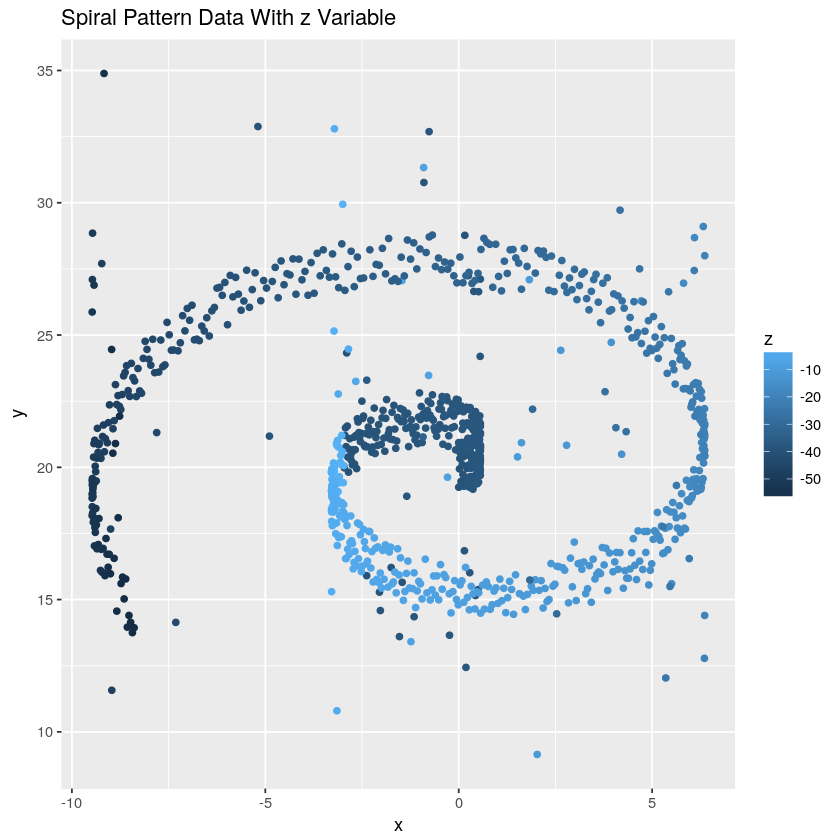

In [6]:
# look at the data
ggplot(dat) + 
  geom_point(aes(x = x, y = y, color = z)) + 
  ggtitle('Spiral Pattern Data With z Variable')

## Step 2: Multiple Linear Regression: y ~ x + z
First, we will try multiple linear regression, a very common modeling method. Looking at the result, the linear regression method indicates a signifificant relationship between the desriptors and the target variable, but does not fit very well, and thus is not usable for prediction. Usually, we would dig deeper into the data, explore the assumptions more, and try some transformations to get a better result from the model. But here, we will just move on to demonstrate the neural network. 

In [8]:
# Try Linear Regression to get y from x and z
lin_test <- lm(y ~ x + z, data = dat)
summary(lin_test)


Call:
lm(formula = y ~ x + z, data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.3063  -2.5195  -0.6216   2.1616  15.2089 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 17.766794   0.248514  71.492  < 2e-16 ***
x            0.158315   0.030232   5.237 1.99e-07 ***
z           -0.114319   0.008128 -14.065  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.669 on 998 degrees of freedom
Multiple R-squared:  0.1666,	Adjusted R-squared:  0.1649 
F-statistic: 99.73 on 2 and 998 DF,  p-value: < 2.2e-16


### Plot the result of linear regression
From the plot, it is clear that the linear regression method struggles to explain the non-linearity of the data.

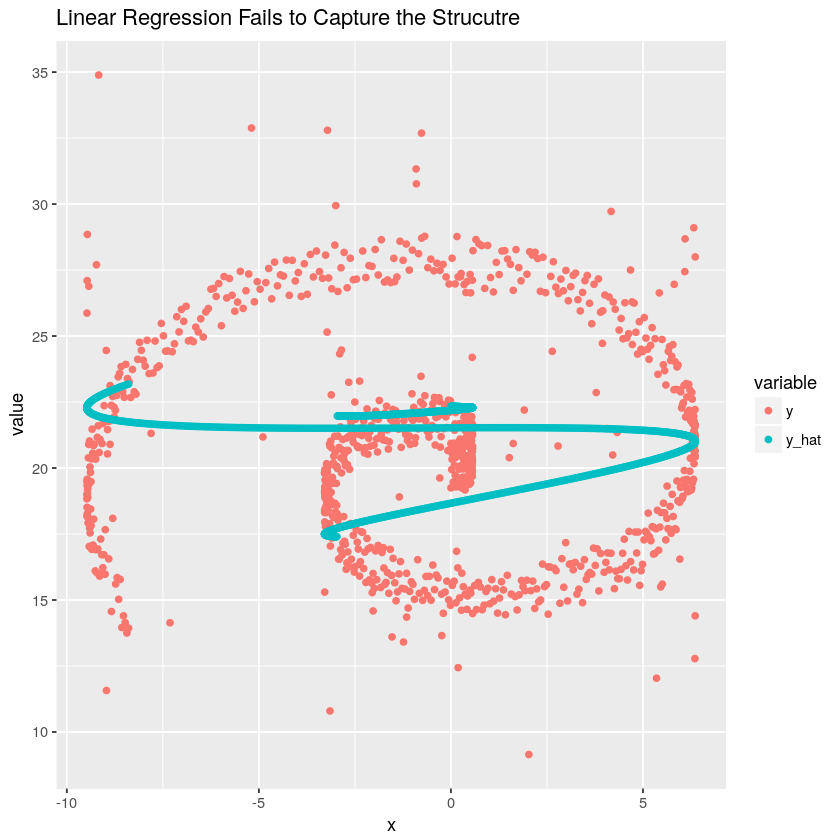

In [9]:
# build a y vs y hat figure to compare 
fit = data.frame(x = dat$x, y = dat$y, y_hat = lin_test$fitted.values)

gg_dat <- melt(fit, 1)

# look at just the x, y and y hat
ggplot(gg_dat) + 
  geom_point(aes(x = x, y = value, color = variable)) + 
  ggtitle('Linear Regression Fails to Capture the Strucutre ')


## Step 3: Prepare Data for the neural network
To train the neural network, the data set is split into train and test sets. First though, the data are scaled and centered. This is a simple reversible operation done to assist the neural network based off its activation function range. Sometimes you can get away without this step, and many methods available as code packages now do operations like this automatically, but here, we demonstrate the method to better understand the process. Notice, the structure of the scaled data doesn't change, just the range and location of the scatter plot.  

In [10]:
# prepare the data for the neural net
# find the min and max for scaling
max <- apply(dat, 2, max)
min <- apply(dat, 2, min)


# use the base function scale to prepare the data
scaled <- scale(dat, center = min, scale = max - min)

# sub sample to get the test and train set to check model performance later 
index <- seq(1, nrow(dat))
train_index <- sample(index, 0.8*length(index))
train <- scaled[train_index,]
test <- scaled[-train_index,]

### Plot the Scaled Data
The data have been scaled and moved, but the structure remains unchanged. The range is easier for the neural netowork to fit to, and the scaling and centering operations are easily reversed. 

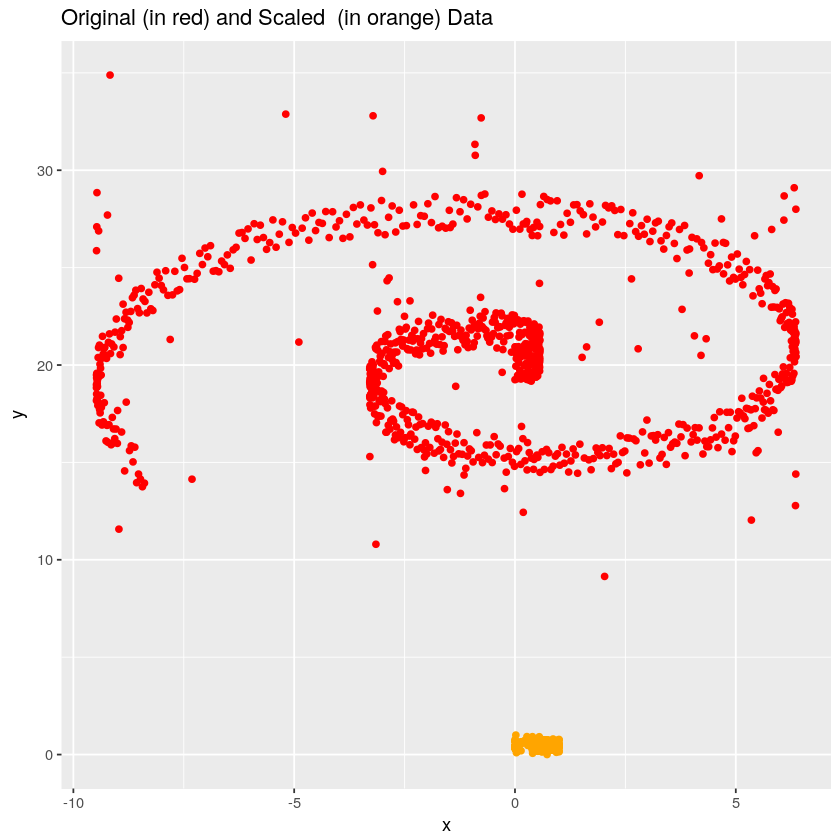

In [12]:
# view the Data change
original_x <- dat[,1]
original_y <- dat[,2]

scaled_x <- scaled[,1]
scaled_y <- scaled[,2]

# make before and after data
original <- data.frame(x = original_x, y = original_y)
scaled <- data.frame(x = scaled_x, y = scaled_y)

# look at original and scaled data. 
ggplot() +
  geom_point(data = original, aes(x = x, y = y), color = 'red') + 
  geom_point(data = scaled, aes(x = x, y = y), color = 'orange') +
  ggtitle('Original (in red) and Scaled  (in orange) Data')

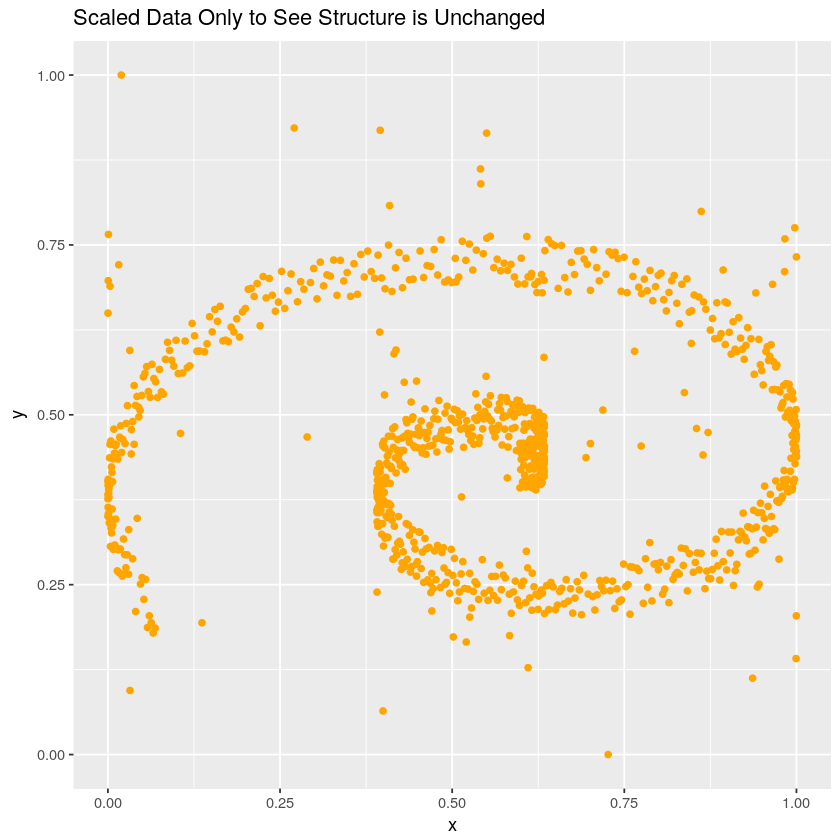

In [13]:
### Plot just the Scaled Data
ggplot() +
  geom_point(data = scaled, aes(x = x, y = y), color = 'orange') +
  ggtitle('Scaled Data Only to See Structure is Unchanged')

### Plot the Train and Test Data
Plotting both the train and test data helps to see if the test set is a good representation of the training set. If it is not, then the results may not be indicative of the general model performance. Here, the test data seems to be a good represenation of the training data. 

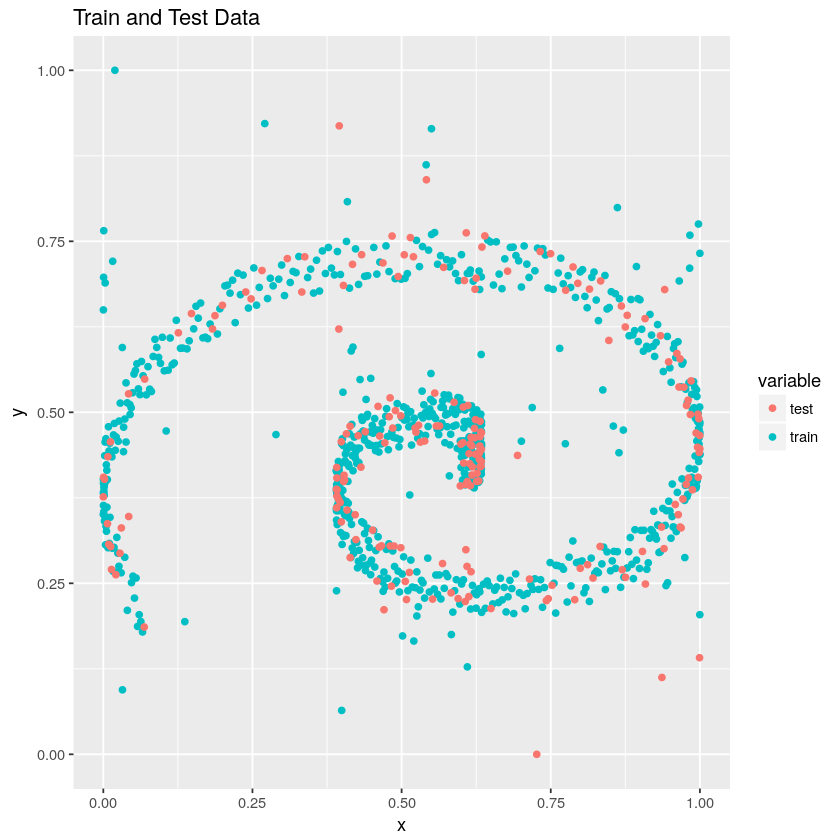

In [14]:
# look at train and test data
# make a train / test data frame for plotting
variable = as.factor(c(rep('train', nrow(train)), rep('test', nrow(test))))
x <- c(train[,1], test[,1])
y <- c(train[,2], test[,2])

train_test_compare <- data.frame(x, y, variable)

# Plot the train and test data 
ggplot(train_test_compare) + 
  geom_point(aes(x = x, y = y, color = variable)) + 
  ggtitle('Train and Test Data')

## Step 4: Setup and Train the Neural Network

Here we set up and train the neural network. There are a number of arguments that make a big difference in how the training goes. These are called hyperparameters and need to be adjusted for each problem individually. In this implementation of neural nets two of the most important hyperparameters are learning rate, and threshold. Thesehyper parameters dictate how much the weights are changed as you step through the backpropagation process. 

In [16]:
# first set random seed to a lucky number
set.seed(2)

# setup and train the neural network 
net <- neuralnet(y ~ x + z, 
        data = train, 
        hidden = c(6, 3), 
        threshold = 0.015, # if you network does not run, try turning this up just a little
        stepmax = 1e+06, 
        rep = 1, 
        #startweights = NULL,
        #learningrate.limit = NULL,
        #learningrate.factor = list(minus = 0.5, plus = 1.2),
        learningrate = 0.0008, 
        lifesign = "full",
        #lifesign.step = 1000, 
        algorithm = "backprop",
        err.fct = 'sse', 
        act.fct = "logistic",
        linear.output = TRUE, 
        exclude = NULL,
        constant.weights = NULL)

hidden: 6, 3    thresh: 0.015    rep: 1/1    steps:    1000	min thresh: 0.2258988286
                                                       2000	min thresh: 0.2258988286
                                                       3000	min thresh: 0.2258988286
                                                       4000	min thresh: 0.2258988286
                                                       5000	min thresh: 0.2258988286
                                                       6000	min thresh: 0.2258988286
                                                       7000	min thresh: 0.2258988286
                                                       8000	min thresh: 0.2241568946
                                                       9000	min thresh: 0.2173232988
                                                      10000	min thresh: 0.2139147199
                                                      11000	min thresh: 0.2067387675
                                                      12000	min t

                                                      97000	min thresh: 0.1421211273
                                                      98000	min thresh: 0.1421211273
                                                      99000	min thresh: 0.1421211273
                                                     100000	min thresh: 0.1421211273
                                                     101000	min thresh: 0.1421211273
                                                     102000	min thresh: 0.1421211273
                                                     103000	min thresh: 0.1421211273
                                                     104000	min thresh: 0.1421211273
                                                     105000	min thresh: 0.1421211273
                                                     106000	min thresh: 0.1421211273
                                                     107000	min thresh: 0.1421211273
                                                     108000	min t

                                                     193000	min thresh: 0.1421211273
                                                     194000	min thresh: 0.1421211273
                                                     195000	min thresh: 0.1421211273
                                                     196000	min thresh: 0.1421211273
                                                     197000	min thresh: 0.1421211273
                                                     198000	min thresh: 0.1421211273
                                                     199000	min thresh: 0.1421211273
                                                     200000	min thresh: 0.1421211273
                                                     201000	min thresh: 0.1421211273
                                                     202000	min thresh: 0.1421211273
                                                     203000	min thresh: 0.1421211273
                                                     204000	min t

                                                     289000	min thresh: 0.1421211273
                                                     290000	min thresh: 0.1421211273
                                                     291000	min thresh: 0.1421211273
                                                     292000	min thresh: 0.1421211273
                                                     293000	min thresh: 0.1421211273
                                                     294000	min thresh: 0.1421211273
                                                     295000	min thresh: 0.1421211273
                                                     296000	min thresh: 0.1421211273
                                                     297000	min thresh: 0.1421211273
                                                     298000	min thresh: 0.1421211273
                                                     299000	min thresh: 0.1421211273
                                                     300000	min t

                                                     385000	min thresh: 0.1421211273
                                                     386000	min thresh: 0.1421211273
                                                     387000	min thresh: 0.1421211273
                                                     388000	min thresh: 0.1421211273
                                                     389000	min thresh: 0.1421211273
                                                     390000	min thresh: 0.1421211273
                                                     391000	min thresh: 0.1421211273
                                                     392000	min thresh: 0.1421211273
                                                     393000	min thresh: 0.1421211273
                                                     394000	min thresh: 0.1421211273
                                                     395000	min thresh: 0.1421211273
                                                     396000	min t

                                                     481000	min thresh: 0.1421211273
                                                     482000	min thresh: 0.1421211273
                                                     483000	min thresh: 0.1421211273
                                                     484000	min thresh: 0.1421211273
                                                     485000	min thresh: 0.1421211273
                                                     486000	min thresh: 0.1421211273
                                                     487000	min thresh: 0.1421211273
                                                     488000	min thresh: 0.1421211273
                                                     489000	min thresh: 0.1421211273
                                                     490000	min thresh: 0.1421211273
                                                     491000	min thresh: 0.1421211273
                                                     492000	min t

### View and plot the resulting network

Next, we can plot a graph of the neural net to get an idea of the resulting model.

In [81]:
# View the structure of the neural net
plot(net)

In [78]:
# View some results and weights in a table
net$result.matrix

,1
error,2.90164507980
reached.threshold,0.01498142697
steps,567151.00000000000
Intercept.to.1layhid1,-1.80822487177
x.to.1layhid1,0.39777400678
z.to.1layhid1,4.64410745494
Intercept.to.1layhid2,-0.23806672128
x.to.1layhid2,-5.36041938876
z.to.1layhid2,-0.53575169588
Intercept.to.1layhid3,-0.17894032502


In [79]:
## Step 5: Make Predictions

In [22]:
# make the predictions on the train data
nn_prediction = compute(net, train[,c(1, 3)])

# un-scale the predictions
unscaled_train_prediction = (nn_prediction$net.result * (max(dat$y) - min(dat$y))) + min(dat$y)

train_x = (train[,1] * (max(dat$x) - min(dat$x))) + min(dat$x)
train_y = (train[,2] * (max(dat$y) - min(dat$y))) + min(dat$y)


# make predictions on the test data
nn_prediction = compute(net, test[, c(1, 3)])

# un-scale
unscaled_test_prediction = (nn_prediction$net.result * (max(dat$y) - min(dat$y))) + min(dat$y)

test_x = (test[,1] * (max(dat$x) - min(dat$x))) + min(dat$x)
test_y = (test[,2] * (max(dat$y) - min(dat$y))) + min(dat$y)


### Plot the resulting predictions

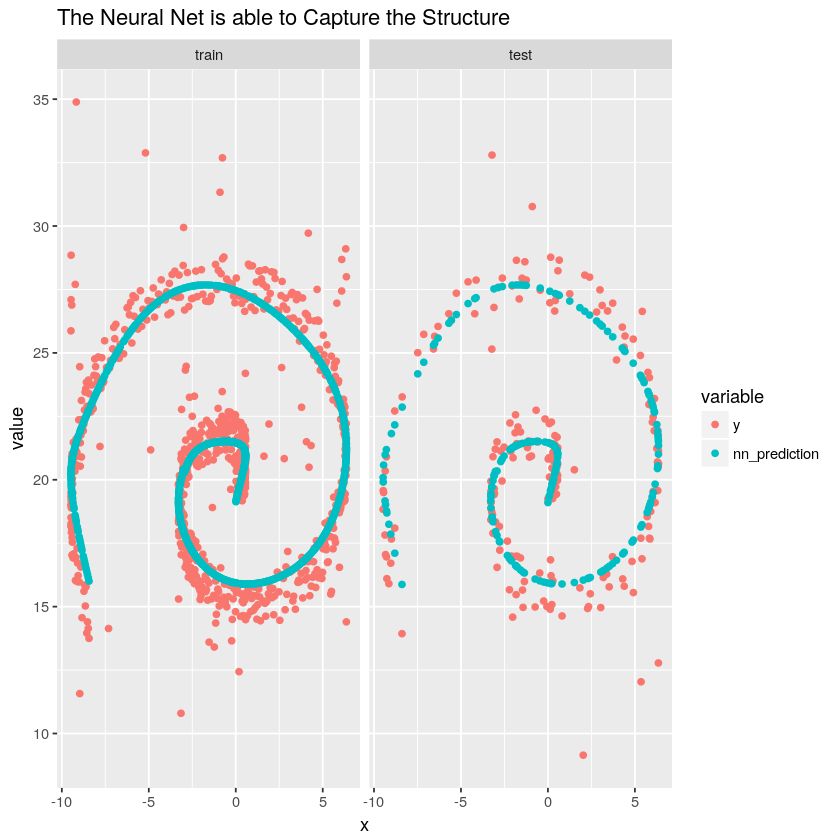

In [24]:
# plot the train and test and predictions
train_fit <- data.frame(x = train_x, y = train_y, nn_prediction = unscaled_train_prediction, data_set = 'train')
test_fit = data.frame(x = test_x, y = test_y, nn_prediction = unscaled_test_prediction, data_set = 'test')

result <- rbind(train_fit, test_fit)
result$data_set <- as.factor(result$data_set)

plot_frame <- melt(result, c(1, 4))

ggplot(plot_frame) + 
  geom_point(aes(x = x, y = value, color = variable)) + 
  ggtitle('The Neural Net is able to Capture the Structure') +
  facet_grid(~data_set)


## Summary

You can see how the neural network is able to capture the structure of a function too complex for the linear regression to model well, even with a very small network and just a short amount of training. 